In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
import math
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
# import preprocessor script from 'crude-oil-forecast' directory
from common.preprocessor import load_data, mape

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")


In [2]:
data = load_data('./data', 'Commodity Prices Monthly.csv')[['Price']]

In [3]:
data.head()

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


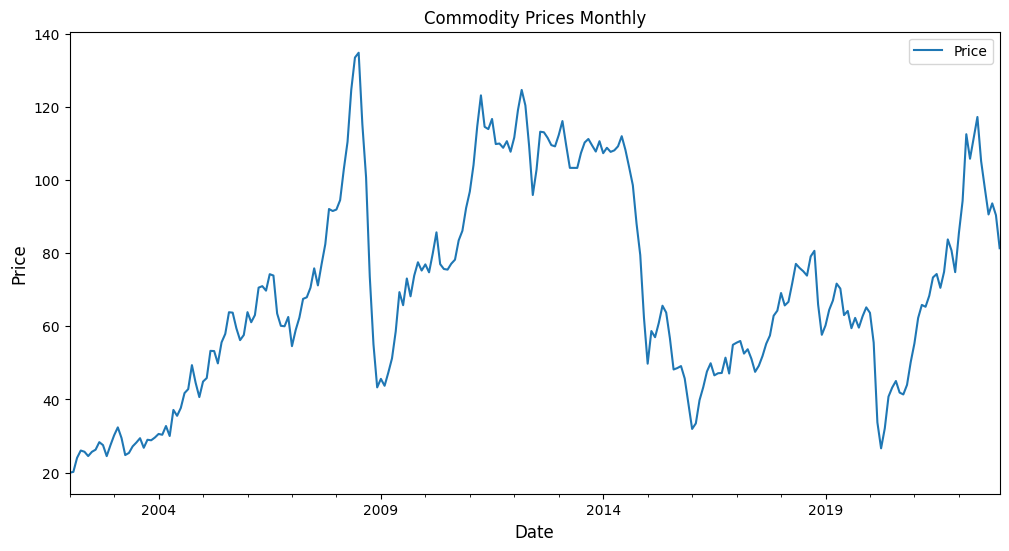

In [4]:
data.plot(y='Price', title='Commodity Prices Monthly', figsize=(12, 6))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [5]:
#create training and testing datasets
train, test = train_test_split(data, test_size=0.05, shuffle=False)

In [6]:
train.shape, test.shape

((239, 1), (13, 1))

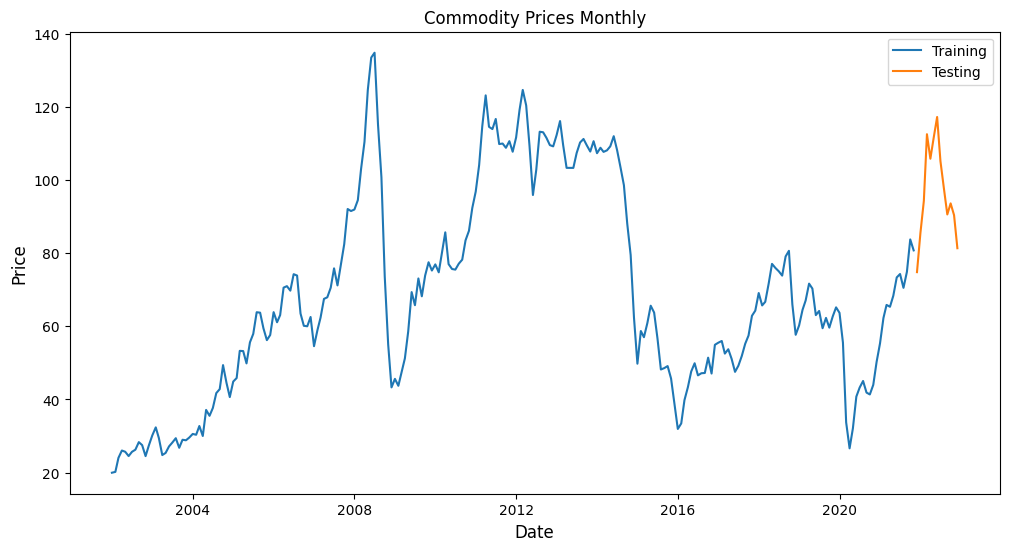

In [7]:
# visualize the training and testing datasets
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.title('Commodity Prices Monthly')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.show()

In [8]:
# prepare data for training
scaler = MinMaxScaler()
train['Price'] = scaler.fit_transform(train[['Price']])
train.head()

,Price
2002-01-01,0.00
2002-02-01,0.00
2002-03-01,0.04
2002-04-01,0.05
2002-05-01,0.05


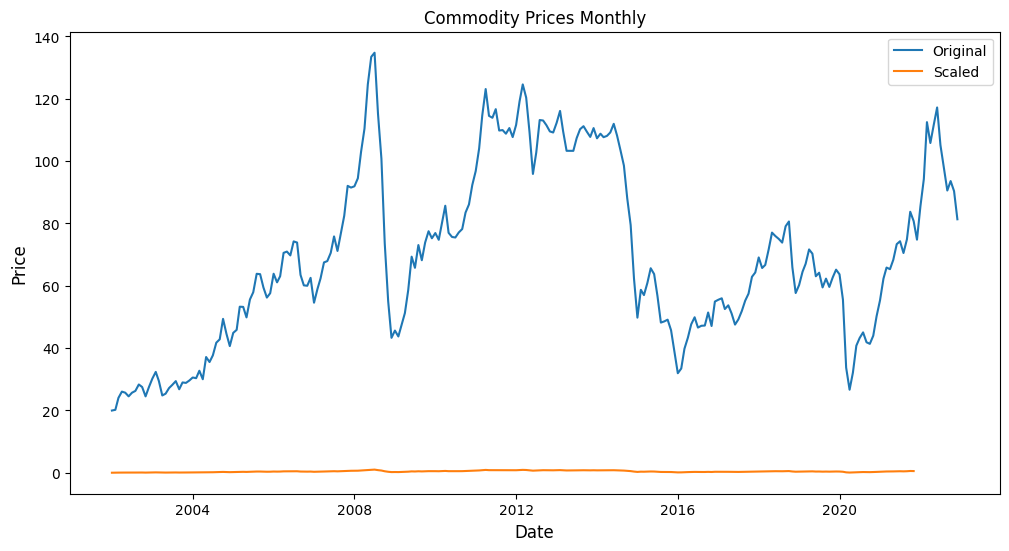

In [9]:
# visualize the original vs scaled data 
plt.figure(figsize=(12, 6))
plt.plot(data['Price'], label='Original')
plt.plot(train['Price'], label='Scaled')
plt.title('Commodity Prices Monthly')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.show()

# If the results for original vs scaled data aren't the same what do I do?
# I think I can use the original data for training and testing



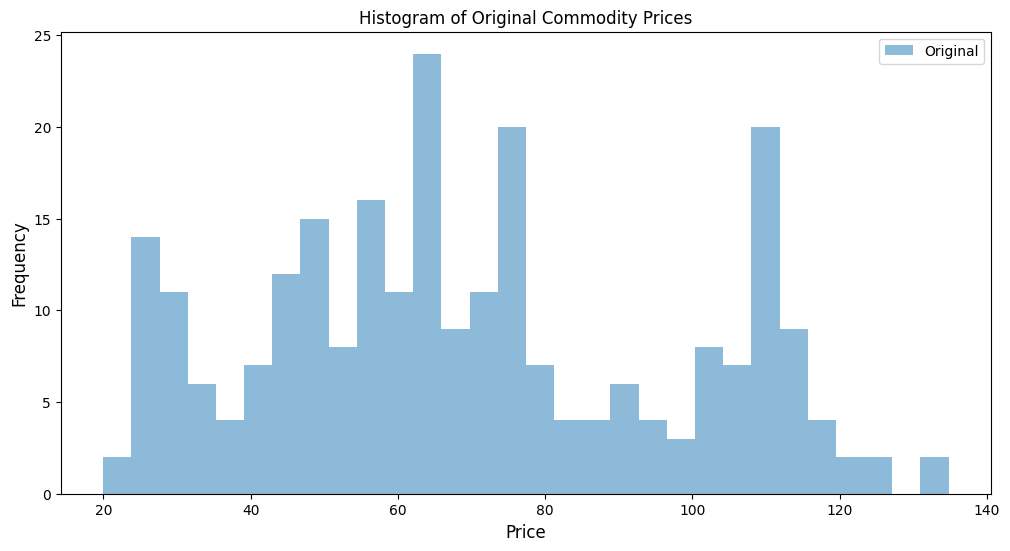

In [10]:
# Plot original data
plt.figure(figsize=(12, 6))
plt.hist(data['Price'], bins=30, alpha=0.5, label='Original')
plt.title('Histogram of Original Commodity Prices')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

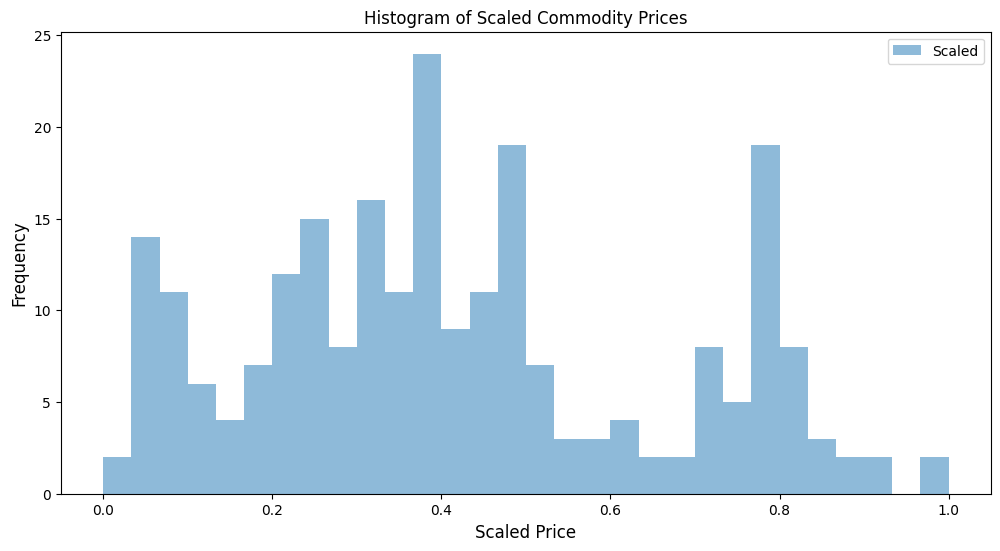

In [11]:
# Plot scaled data
plt.figure(figsize=(12, 6))
plt.hist(train['Price'], bins=30, alpha=0.5, label='Scaled')
plt.title('Histogram of Scaled Commodity Prices')
plt.xlabel('Scaled Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

In [12]:
# scale test data
test['Price'] = scaler.fit_transform(test[['Price']])
test.head()

,Price
2021-12-01,0.00
2022-01-01,0.25
2022-02-01,0.46
2022-03-01,0.89
2022-04-01,0.73


In [13]:
# use auto arima to find the best parameters
model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1,max_d=2, D=1,max_D=2, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-545.700, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-630.461, Time=0.43 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-587.825, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-661.564, Time=0.76 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-623.959, Time=0.71 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-659.681, Time=1.29 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-659.636, Time=1.59 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-655.255, Time=0.76 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-657.566, Time=1.04 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=-659.568, Time=1.69 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]  

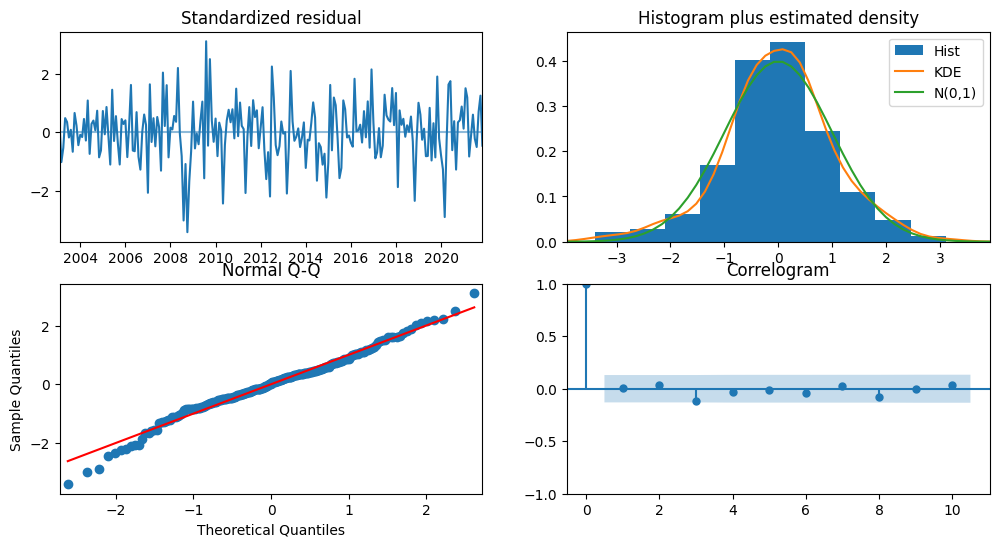

In [14]:
plot = model.plot_diagnostics(figsize=(12, 6))

In [15]:
#check to see if data is stationary
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'No. of lags used: {result[2]}')
    print(f'No. of observations used: {result[3]}')
    print('Critical Values:')
    for k, v in result[4].items():
        print(f'   {k}: {v}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(train['Price'])

ADF Statistic: -2.802743449850864
p-value: 0.0578829531354702
No. of lags used: 1
No. of observations used: 237
Critical Values:
   1%: -3.4582467982399105
   5%: -2.8738137461081323
   10%: -2.5733111490323846
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [16]:
HORIZON = 3
print(f'Forecasting {HORIZON} months')

Forecasting 3 months


In [17]:
# create test data point for each horizon step
test_shifted = test.copy()
for t in range(1, HORIZON+1):
    test_shifted[f'Price+{t}'] = test_shifted['Price'].shift(-t, freq='MS')
test_shifted = test_shifted.dropna(how='any') # remove rows with NaNs
test_shifted.head()

,Price,Price+1,Price+2,Price+3
2021-12-01,0.00,0.25,0.46,0.89
2022-01-01,0.25,0.46,0.89,0.73
2022-02-01,0.46,0.89,0.73,0.87
2022-03-01,0.89,0.73,0.87,1.00
2022-04-01,0.73,0.87,1.00,0.72


In [18]:
%%time
from statsmodels.tsa.statespace.sarimax import SARIMAX

# train the model
train_window = len(train)

train_ts = train['Price']
test_ts = test_shifted['Price']

history = [x for x in train_ts]
history = history[-train_window:]
predictions = list()

order = (1,1,0)
seasonal_order = (1,1,0,12)

for t in range(len(test_ts)):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=HORIZON)
    predictions.append(yhat)
    obs = test_ts.iloc[t]
    history.append(obs) # move the training window
    history.pop(0)
    print(f'Month={t+1}, predicted={yhat}, expected={obs}')


Month=1, predicted=[0.55 0.56 0.56], expected=0.0
Month=2, predicted=[-0.22 -0.32 -0.42], expected=0.2517680339462518
Month=3, predicted=[0.3  0.25 0.22], expected=0.45921735030645916
Month=4, predicted=[0.45 0.43 0.47], expected=0.8889674681753892
Month=5, predicted=[1.01 1.08 1.15], expected=0.7310231023102314
Month=6, predicted=[0.74 0.78 0.79], expected=0.8663366336633662
Month=7, predicted=[0.94 0.96 0.94], expected=1.0
Month=8, predicted=[1.03 1.02 1.03], expected=0.7152286657237155
Month=9, predicted=[0.64 0.64 0.69], expected=0.5407826496935408
Month=10, predicted=[0.52 0.57 0.56], expected=0.3717586044318715
CPU times: total: 312 ms
Wall time: 3.63 s


In [19]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
len(eval_df)

10

In [20]:
len((test_shifted.index))

10

In [21]:
test.shape

(13, 1)

In [22]:
# COMPARE THE PREDICTION TO ACTUAL VALUES
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON]


In [23]:
eval_df

,t+1,t+2,t+3,timestamp
0,0.55,0.56,0.56,2021-12-01
1,-0.22,-0.32,-0.42,2022-01-01
2,0.30,0.25,0.22,2022-02-01
3,0.45,0.43,0.47,2022-03-01
4,1.01,1.08,1.15,2022-04-01
5,0.74,0.78,0.79,2022-05-01
6,0.94,0.96,0.94,2022-06-01
7,1.03,1.02,1.03,2022-07-01
8,0.64,0.64,0.69,2022-08-01
9,0.52,0.57,0.56,2022-09-01


In [24]:
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df

,timestamp,h,prediction
0,2021-12-01,t+1,0.55
1,2022-01-01,t+1,-0.22
2,2022-02-01,t+1,0.30
3,2022-03-01,t+1,0.45
4,2022-04-01,t+1,1.01
5,2022-05-01,t+1,0.74
6,2022-06-01,t+1,0.94
7,2022-07-01,t+1,1.03
8,2022-08-01,t+1,0.64
9,2022-09-01,t+1,0.52


In [25]:
test_ts = pd.DataFrame( test_ts)
# transpose test_ts
test_ts = test_ts.T
test_ts
test_ts_array = test_ts.values.ravel()

In [26]:
test_ts_array

array([0.  , 0.25, 0.46, 0.89, 0.73, 0.87, 1.  , 0.72, 0.54, 0.37])

In [27]:

eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

KeyError: "['actual'] not in index"

In [28]:
# calculate the mean absolute percentage error
mape(eval_df['prediction'], eval_df['actual'])

KeyError: 'actual'

In [29]:
# let's use support vector regressor
from sklearn.svm import SVR

train_data = train.values
test_data = test.values

print(train_data.shape, test_data.shape)

(239, 1) (13, 1)


In [30]:
timesteps=5

In [31]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(235, 5)

In [32]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(9, 5)

In [33]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(235, 4) (235, 1)
(9, 4) (9, 1)


In [34]:
# modeling
model = SVR(kernel='rbf', C=10, gamma=0.5, epsilon=0.05)
# what does C, gamma , epsilon stand for?
# C is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly.
# Gamma is a parameter for non linear hyperplanes. The higher the gamma value it tries to exactly fit the training data set
# Epsilon is the margin of tolerance where no penalty is given to errors.

In [35]:
model.fit(x_train, y_train)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [36]:
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [37]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(235, 1) (9, 1)


In [38]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

235 9


In [39]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

235 9


In [40]:
# from sklearn.model_selection import train_test_split

# create training and testing datasets
train, test = train_test_split(data, test_size=0.05, shuffle=False)

print(len(train), len(test))

239 13


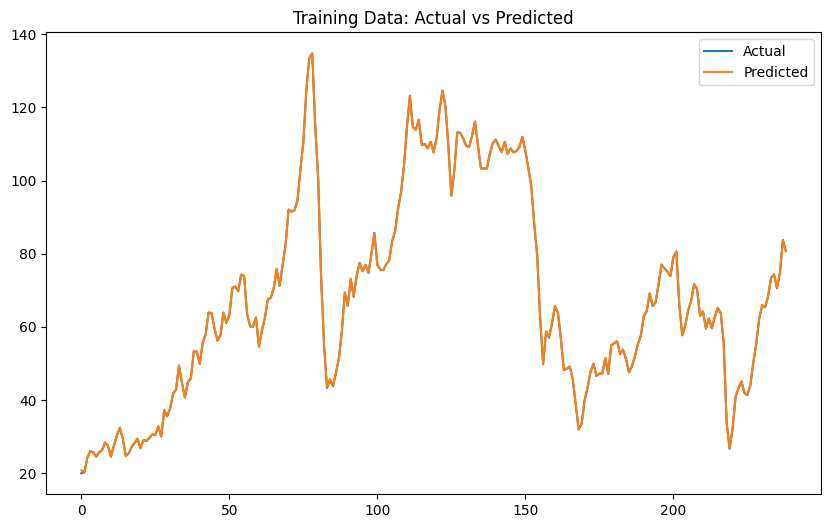

In [41]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# Fit the SVR model
model_svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
model_svr.fit(train[['Price']], train['Price'])

# Generate predictions
train_predictions = model_svr.predict(train[['Price']])

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(train['Price'].values, label='Actual')
plt.plot(train_predictions, label='Predicted')
plt.title('Training Data: Actual vs Predicted')
plt.legend()
plt.show()

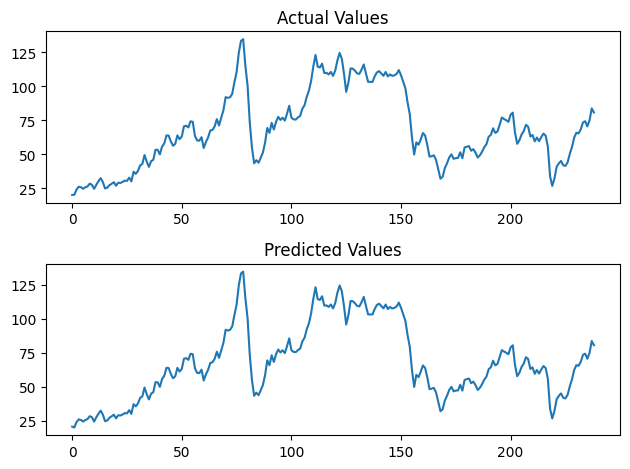

In [42]:
import matplotlib.pyplot as plt

# Generate predictions
train_predictions = model_svr.predict(train[['Price']])

# Create subplots
fig, axs = plt.subplots(2)

# Plot actual values
axs[0].plot(train['Price'].values, label='Actual')
axs[0].set_title('Actual Values')

# Plot predicted values
axs[1].plot(train_predictions, label='Predicted')
axs[1].set_title('Predicted Values')

# Display the plot
plt.tight_layout()
plt.show()

In [43]:
print('MAPE for training data: ', np.absolute(mape(y_train_pred, y_train))*100, '%')


AttributeError: 'numpy.ndarray' object has no attribute 'abs'

In [44]:
# facebook prophet model
# create a dataframe
train_prophet = train.copy()
train_prophet.reset_index(inplace=True)
train_prophet.columns = ['ds', 'y']
train_prophet.head()


,ds,y
0,2002-01-01,19.96
1,2002-02-01,20.19
2,2002-03-01,24.03
3,2002-04-01,26.03
4,2002-05-01,25.69


In [45]:
# scale data with MinMaxScaler
scaler = MinMaxScaler()
train_prophet['y'] = scaler.fit_transform(train_prophet[['y']])
train_prophet.head()

,ds,y
0,2002-01-01,0.00
1,2002-02-01,0.00
2,2002-03-01,0.04
3,2002-04-01,0.05
4,2002-05-01,0.05


In [46]:
# train model
model_prophet = Prophet(interval_width=0.95, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='additive')
model_prophet.fit(train_prophet)

17:13:53 - cmdstanpy - INFO - Chain [1] start processing
17:13:53 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# create test data
test_prophet = test.copy()
test_prophet.reset_index(inplace=True)
test_prophet.columns = ['ds', 'y']
test_prophet['y'] = scaler.fit_transform(test_prophet[['y']])
test_prophet.head()

,ds,y
0,2021-12-01,0.00
1,2022-01-01,0.25
2,2022-02-01,0.46
3,2022-03-01,0.89
4,2022-04-01,0.73


In [48]:
# make predictions
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='MS')
forecast = model_prophet.predict(test_prophet)
forecast[['ds','yhat']].head()


,ds,yhat
0,2021-12-01,0.19
1,2022-01-01,0.23
2,2022-02-01,0.25
3,2022-03-01,0.25
4,2022-04-01,0.26


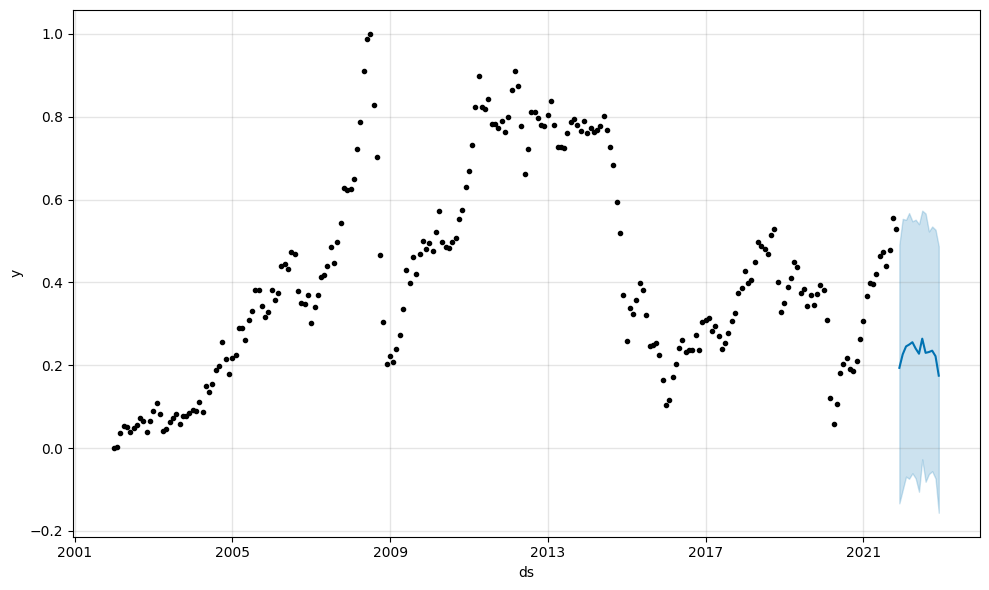

In [49]:
plot = model_prophet.plot(forecast)

In [50]:
#apply on full dataset
full_prophet = data.copy()
full_prophet.reset_index(inplace=True)
full_prophet.columns = ['ds', 'y']
full_prophet['y'] = scaler.fit_transform(full_prophet[['y']])
full_prophet.head()

,ds,y
0,2002-01-01,0.00
1,2002-02-01,0.00
2,2002-03-01,0.04
3,2002-04-01,0.05
4,2002-05-01,0.05


In [51]:
# train model
model_prophet = Prophet(interval_width=0.95, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='additive')
model_prophet.fit(full_prophet)

17:13:56 - cmdstanpy - INFO - Chain [1] start processing
17:13:56 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
# make predictions
future = model_prophet.make_future_dataframe(periods=12, freq='MS')
forecast = model_prophet.predict(future)
forecast[['ds','yhat']].head()

,ds,yhat
0,2002-01-01,0.10
1,2002-02-01,0.11
2,2002-03-01,0.13
3,2002-04-01,0.11
4,2002-05-01,0.13


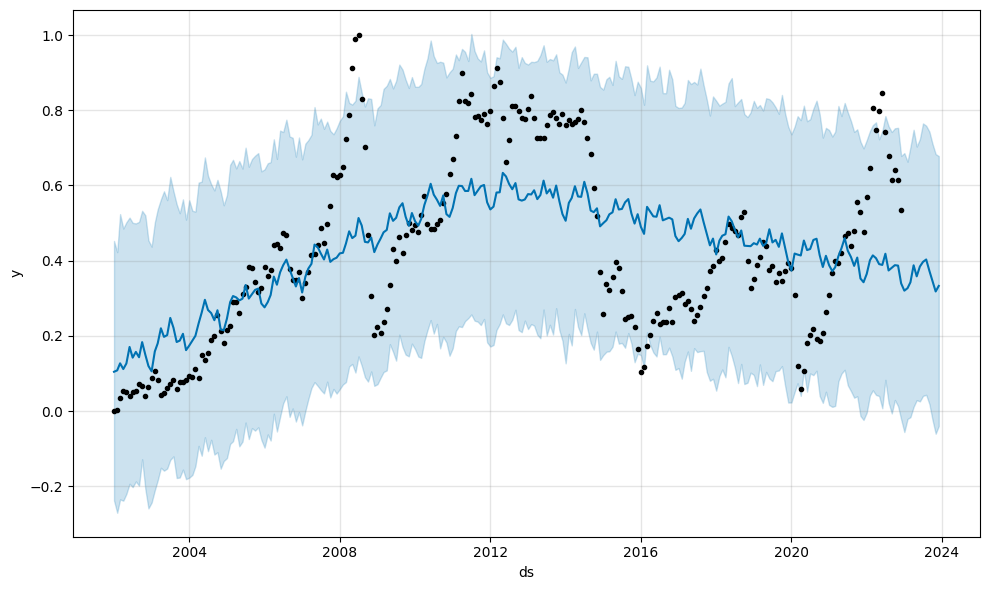

In [53]:
# plot forecast
plot = model_prophet.plot(forecast)

In [54]:
# let's use lstm
# create a dataframe
train_lstm = train.copy()
train_lstm.reset_index(inplace=True)
train_lstm.columns = ['ds', 'y']
#scale the data
scaler = MinMaxScaler()
train_lstm['y'] = scaler.fit_transform(train_lstm[['y']])
train_lstm.head()


,ds,y
0,2002-01-01,0.00
1,2002-02-01,0.00
2,2002-03-01,0.04
3,2002-04-01,0.05
4,2002-05-01,0.05


In [55]:
# create a dataframe
test_lstm = test.copy()
test_lstm.reset_index(inplace=True)
test_lstm.columns = ['ds', 'y']
#scale the data
scaler = MinMaxScaler()
test_lstm['y'] = scaler.fit_transform(test_lstm[['y']])
test_lstm.head()

,ds,y
0,2021-12-01,0.00
1,2022-01-01,0.25
2,2022-02-01,0.46
3,2022-03-01,0.89
4,2022-04-01,0.73


In [56]:
# create a function to prepare the data
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [58]:
# prepare the data
time_steps = 5
X_train, y_train = create_dataset(train_lstm[['y']], train_lstm.y, time_steps)
X_test, y_test = create_dataset(test_lstm[['y']], test_lstm.y, time_steps)
print(X_train.shape, y_train.shape)

(234, 5, 1) (234,)


In [59]:
# create the model
model_lstm = Sequential()
model_lstm.add(LSTM(50,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(50,return_sequences=True))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dense (Dense)               (None, 5, 1)              51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
# train the model
history = model_lstm.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=16, 
    validation_split=0.1,
    verbose=1,
    shuffle=False
)



Epoch 1/30
 7/14 [==============>...............] - ETA: 0s - loss: 0.0248

14/14 [==============================] - 1s 95ms/step - loss: 0.0221 - val_loss: 0.0166
Epoch 2/30
14/14 [==============================] - 0s 17ms/step - loss: 0.0220 - val_loss: 0.0166
Epoch 3/30
14/14 [==============================] - 0s 10ms/step - loss: 0.0218 - val_loss: 0.0165
Epoch 4/30
14/14 [==============================] - 0s 10ms/step - loss: 0.0217 - val_loss: 0.0165
Epoch 5/30
14/14 [==============================] - 0s 13ms/step - loss: 0.0216 - val_loss: 0.0165
Epoch 6/30
14/14 [==============================] - 0s 10ms/step - loss: 0.0215 - val_loss: 0.0165
Epoch 7/30
14/14 [==============================] - 0s 10ms/step - loss: 0.0214 - val_loss: 0.0165
Epoch 8/30
14/14 [==============================] - 0s 10ms/step - loss: 0.0213 - val_loss: 0.0164
Epoch 9/30
14/14 [==============================] - 0s 8ms/step - loss: 0.0212 - val_loss: 0.0164
Epoch 10/30
14/14 [==============================] - 0s 8ms/step - loss: 0.0212 - val_loss: 0.0164
Epoch 11/30
14/14 [===

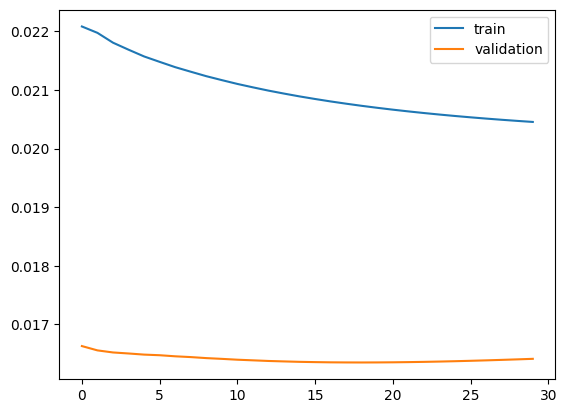

In [63]:
# plot the training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import mean_squared_error
# make predictions
y_train_pred = model_lstm.predict(X_train)
y_test_pred = model_lstm.predict(X_test)



1/1 [==============================] - 0s 24ms/step


In [74]:
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


In [75]:
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)


In [76]:
math.sqrt(mean_squared_error(y_train,y_train_pred))

ValueError: Found input variables with inconsistent numbers of samples: [234, 1170]

In [77]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,y_train_pred))

ValueError: Found input variables with inconsistent numbers of samples: [234, 1170]

In [78]:
# mean absolute percentage error
print('MAPE for training data: ', np.abs(mape(y_train_pred, y_train))*100, '%')
print('MAPE for testing data: ', np.abs(mape(y_test_pred, y_test))*100, '%')


ValueError: operands could not be broadcast together with shapes (1170,1) (234,1) 

In [79]:
# LSTM model
# reshape input to be [samples, time steps, features]
train_lstm = np.reshape(train['Price'].values, (train.shape[0], 1, 1))
model_lstm = Sequential()
model_lstm.add(LSTM(4, input_shape=(1, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(train_lstm, train['Price'], epochs=100, batch_size=1, verbose=2)


Epoch 1/100
239/239 - 2s - loss: 5347.2300 - 2s/epoch - 7ms/step
Epoch 2/100
239/239 - 0s - loss: 5129.1973 - 283ms/epoch - 1ms/step
Epoch 3/100
239/239 - 0s - loss: 4947.4150 - 305ms/epoch - 1ms/step
Epoch 4/100
239/239 - 0s - loss: 4840.6196 - 368ms/epoch - 2ms/step
Epoch 5/100
239/239 - 0s - loss: 4743.3779 - 279ms/epoch - 1ms/step
Epoch 6/100
239/239 - 0s - loss: 4650.5239 - 281ms/epoch - 1ms/step
Epoch 7/100
239/239 - 0s - loss: 4560.5034 - 279ms/epoch - 1ms/step
Epoch 8/100
239/239 - 0s - loss: 4472.3735 - 278ms/epoch - 1ms/step
Epoch 9/100
239/239 - 0s - loss: 4261.7402 - 275ms/epoch - 1ms/step
Epoch 10/100
239/239 - 0s - loss: 4136.9292 - 284ms/epoch - 1ms/step
Epoch 11/100
239/239 - 0s - loss: 4028.6824 - 298ms/epoch - 1ms/step
Epoch 12/100
239/239 - 0s - loss: 3926.7104 - 284ms/epoch - 1ms/step
Epoch 13/100
239/239 - 0s - loss: 3829.2200 - 351ms/epoch - 1ms/step
Epoch 14/100
239/239 - 0s - loss: 3735.2007 - 295ms/epoch - 1ms/step
Epoch 15/100
239/239 - 0s - loss: 3643.8413 - 